#### Imports

In [87]:
import pandas as pd
import numpy as np

import re
import pymorphy3
import nltk
import spacy

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import requests
import folium

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from fuzzywuzzy import fuzz

from tqdm import tqdm

In [88]:
# открытие файла с романом "Идиот"
with open('book.txt', 'r', encoding='cp1251') as file: 
    book = file.read()

In [89]:
book[:50]

'ЧАСТЬ ПЕРВАЯ\n\n\nI.\n\n\nВ конце ноября, в оттепель, ча'

#### Preprocessing

In [90]:
# nltk.download('popular')
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('stopwords')

In [91]:
# изменение списка стоп-слов
stop_words = set(stopwords.words('russian'))
stop_words_adds = ['это','мочь',  'все', 'весь', 'свой', 'твой', 'мой', 'еще', 'знать', 'говорить', 'сказать', 'который', 'очень', 'стать', 'хотеть', 'видеть', 'смотреть', 'чрез', 'спросить', 'сейчас', 'тотчас', 'начать', 'хотя', 'именно', 'давеча', 'сделать', 'тут', 'вдруг', 'пройти', 'кроме', 'впоследствии', 'здесь', 'пять', 'аль', 'эвона', 'эк', 'фью', 'ай', 'самый', 'ваш', 'слишком', 'точно', 'несколько']
stop_words.update(stop_words_adds)

In [92]:
morph = pymorphy3.MorphAnalyzer()

def preprocess(text):
    """разделение слов на токены и проверка на вхождение в список стоп-слов и список пунктуаций"""
    tokens = word_tokenize(text)
    preprocessed_text = []
    for token in tokens:
        if len(token) > 1 and token:
            if morph.parse(token)[0].normal_form.lower().replace('ё', 'е') not in stop_words and token.isalpha():
                preprocessed_text.append(token)
    return " ".join(preprocessed_text)

In [93]:
# разделение на предложения
book = book.replace('\n', '')
sentences = re.split(r'[.!?]+', book) 

In [94]:
processed_sentences = [preprocess(sentence) for sentence in sentences]

In [95]:
punctuation_marks = set(['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '-'])

Нормализация слов

In [96]:
def get_lemma(text):
    """лемматизация слов"""
    text_parts = text.split()
    lemma = []
    for w in text_parts:
        if w not in punctuation_marks:
            lemma.append(morph.parse(w)[0].normal_form.replace('ё', 'е'))
    return lemma

In [97]:
# cоздание списка нормализованных токенов для анализа дисперсии и анализа частотности слов
book_ = ' '.join(processed_sentences)
words = ' '.join(get_lemma(book_)).split()

In [98]:
words[:10]

['часть',
 'перваяi',
 'конец',
 'ноябрь',
 'оттепель',
 'час',
 'девять',
 'утро',
 'поезд',
 'железный']

In [99]:
# нормализация предложений
sentences_ = [get_lemma(sentence) for sentence in processed_sentences]

In [100]:
sentence_to_list = [' '.join(lst) for lst in sentences_]

df = pd.DataFrame(zip(sentences, sentence_to_list),  columns=['sentences', 'sentences_clear']).dropna() # датафрейм из предложений романа
df.to_csv('sentences.csv', index=False)

#### Frequency

In [27]:
pattern_parts = r'\bЧАСТЬ\s+\w+\b'
chapters = re.findall(pattern_parts, book)
print(*chapters, sep = '\n')

ЧАСТЬ ПЕРВАЯI
ЧАСТЬ ВТОРАЯ
ЧАСТЬ ТРЕТЬЯ
ЧАСТЬ ЧЕТВЕРТАЯ


Историческоий период сюжета романа

In [28]:
numbers = re.findall(r'\d+', book) # поиск чисел в тексте
print(numbers)
print()
print("По всей видимости, в тексте не указывается год событий")

['3', '16', '1', '2', '1', '2']

По всей видимости, в тексте не указывается год событий


In [29]:
# найдем словосочетания со словом "век"
pattern_period = r'\w+\s+\bвек[а-я]\b'

period = re.findall(pattern_period, book)
period = set(period)
print(*period, sep = '\n')

на веки
девятнадцатого века
первые века
от века
своем веку
нашем веке
золотом веке


В романе упоминается "девятнадцатый век", "золотой век" и "наш век". Вероянее всего, действия в романе описываются в период жизни автора романа Ф.М. Достоевского (1821-1881), в девятнадцатом веке.

In [ ]:
# # разделим весь текст на части
parts = re.split(pattern_parts, book)
print(len(parts))

5


In [31]:
part_1 = parts[1] # первое значение в списке пустое, поэтому не записываем значение с индексом 0
part_2 = parts[2]
part_3 = parts[3]
part_4 = parts[4]

In [32]:
lengths = [len(part_1), len(part_2), len(part_3), len(part_4)]
labels = [f'Часть {i}' for i in range(1, 5)]

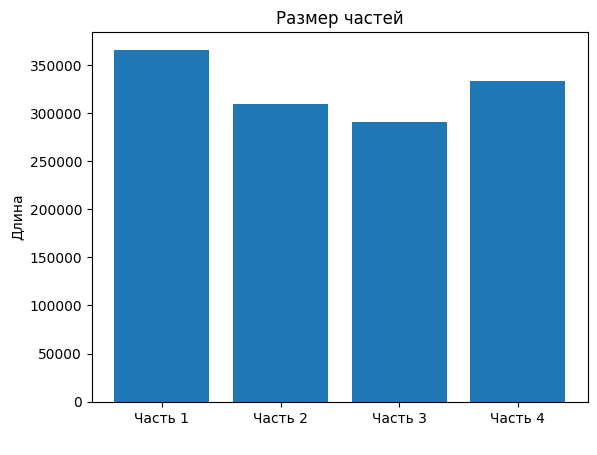

In [33]:
plt.bar(labels, lengths)
plt.xlabel(' ')
plt.ylabel('Длина')
plt.title('Размер частей')
plt.show()

In [34]:
parsed_words = []
for word in words:

    parse = morph.parse(word)[0]
    if 'Patr' not in parse.tag :
        
        parsed_words.append(word)        
counter = Counter(parsed_words)

top_words = counter.most_common(100)

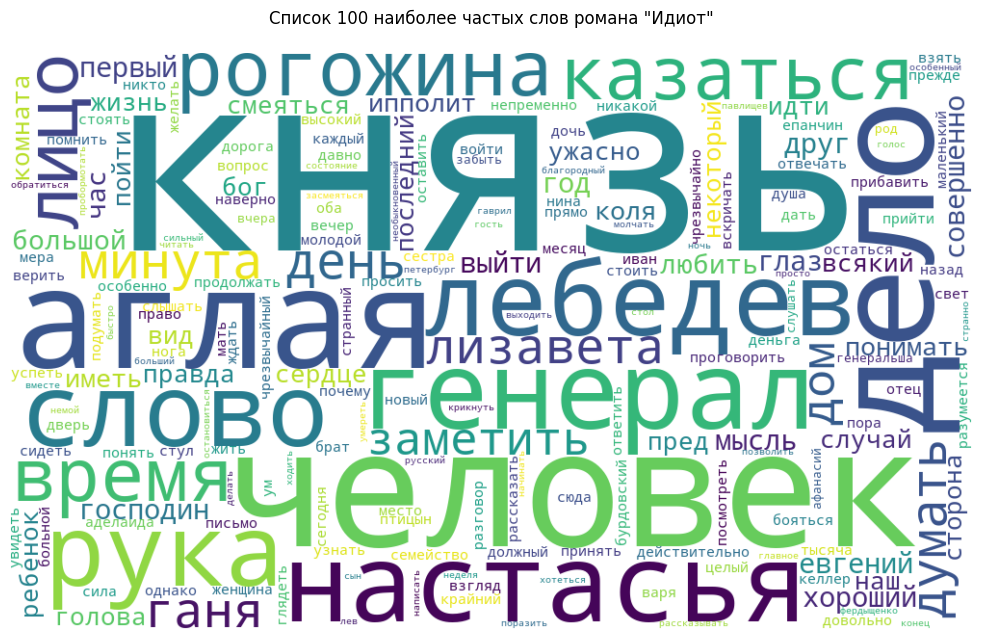

In [35]:
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(counter)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Список 100 наиболее частых слов романа "Идиот"\n')
plt.show()

#### Geographical objects

Упоминание города в тексте может свидетельствовать о местоположении, где происходят события романа, а также о путях передвижения персонажей

In [36]:
nlp = spacy.load("ru_core_news_md")

In [ ]:
def search_entity(marks):
    """поиск именнованных сущностей"""
    entity = []
    
    mid = len(book) // 2
    book_part1 = book[:mid]
    book_part2 = book[mid:]

    for part in [book_part1, book_part2]:
        doc = nlp(part.lower())
        entity_found = [ent.text for ent in doc.ents if ent.label_ in marks]
    entity.extend(entity_found)
    return entity

In [38]:
locations_list = search_entity("LOC")

In [39]:
locations_list = [morph.parse(l)[0].normal_form.title() for l in locations_list if "Name" not in morph.parse(l)[0].tag]

In [40]:
locations_count = pd.Series(locations_list).value_counts()

In [41]:
locations_filtered = locations_count[(locations_count >= 2) &(locations_count.index.str.count(' ') == 0)]

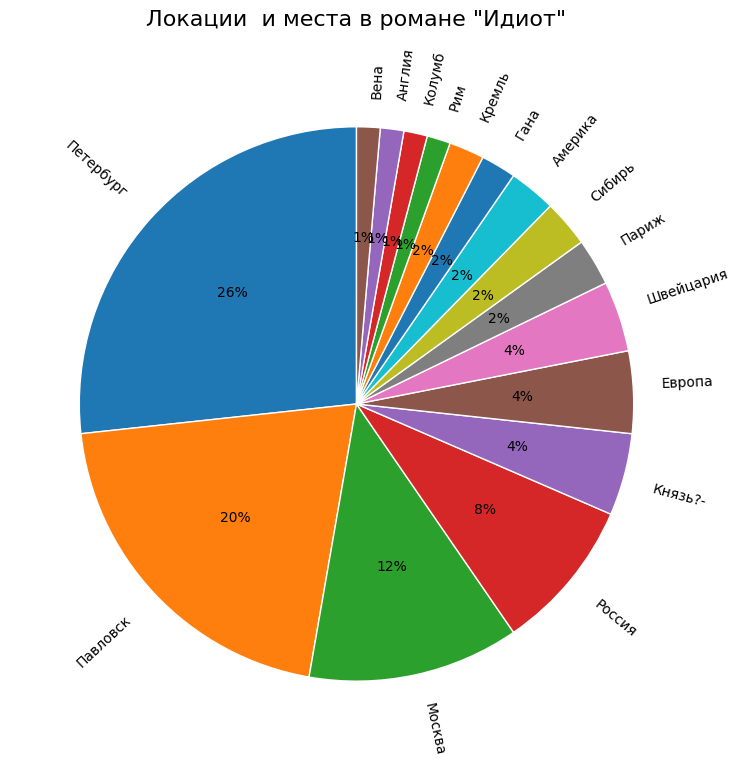

In [42]:
labels = locations_filtered.index
sizes = locations_filtered.values

plt.figure(figsize=(9, 9))
plt.pie(
    sizes,
    labels=labels,
    autopct='%d%%',
    rotatelabels=True,
    startangle=90,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

plt.title('Локации  и места в романе "Идиот"\n', fontsize=16)
plt.show()

In [43]:
locations_df = locations_filtered.reset_index()
locations_df.columns = ['location', 'count']

In [ ]:
def get_coordinates(city_name):
    """получение координат"""
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': city_name,
        'format': 'json',
        'limit': 1
    }
    headers = {'User-Agent': 'MyApp/1.0'}
    response = requests.get(url, params=params, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        if data:
            lat = float(data[0]['lat'])
            lon = float(data[0]['lon'])
            return lat, lon
    return None

In [ ]:
def add_coordinates(df):
    """добавление координатв дф"""
    lats = []
    lons = []

    for index, row in locations_df.iterrows():
        coords = get_coordinates(row['location'])
        if coords:
            lats.append(coords[0])
            lons.append(coords[1])
        else:
            lats.append(None)
            lons.append(None)

    locations_df['latitude'] = lats
    locations_df['longitude'] = lons

    return locations_df

In [46]:
locations_df = add_coordinates(locations_df)

In [47]:
locations_df.head()

,location,count,latitude,longitude
0,Петербург,39,59.960674,30.158655
1,Павловск,30,50.452021,40.139966
2,Москва,18,55.625578,37.606392
3,Россия,13,64.686314,97.745306
4,Князь?-,7,57.052860,44.296737


In [48]:
center_lat = locations_df['latitude'].mean()
center_lon = locations_df['longitude'].mean()

map = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=4,
    min_zoom=4,
    max_zoom=4,
    control_scale=False,        
    zoom_control=False      
)

# Добавляем маркеры
for _, row in locations_df.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=row['location']        
).add_to(map)

In [49]:
map

#### Characters

In [50]:
nlp = spacy.load("ru_core_news_lg")

In [ ]:
def get_characters():
    """поиск имен"""
    names_list = search_entity("PER")  # получение именованных сущностей
    

    def is_name_or_patronymic(word):
        """определение тегов имен"""
        tags = morph.parse(word)[0].tag
        return any(tag in tags for tag in ['Name', 'Surn', 'Patr'])

    def is_valid_name(name):
        """проверка на валидность имен"""
        return all(is_name_or_patronymic(w) for w in name.split())

    names_filtered = [name for name in names_list if is_valid_name(name)]

    def remove_short_words(name):
        """удаление коротких слов"""
        return ' '.join(w for w in name.split() if len(w) > 2)

    names_filtered = [remove_short_words(name) for name in names_filtered]

    def not_only_patronymic(name):
        """удаление строк, состоящих только из отчества"""
        parts = name.split()
        tags_list = [morph.parse(part)[0].tag for part in parts]
        has_patronymic = any('Patr' in tags for tags in tags_list)
        return len(parts) > 1 or not has_patronymic

    names_filtered1 = [name for name in names_filtered if not_only_patronymic(name)]

    names = []
    for name in names_filtered1:
        if not isinstance(name, str):
            names.append(name)
            continue
            
        parts = name.split()
        tags_list = [morph.parse(part)[0].tag for part in parts]

        counts = {
            'Name': sum('Name' in t for t in tags_list),
            'Patr': sum('Patr' in t for t in tags_list),
            'Surn': sum('Surn' in t for t in tags_list),
        }

        for key in ['Name', 'Patr', 'Surn']:
            if counts[key] >= 2:
                target_tag = key
                break
        else:
            target_tag = None

        if target_tag:
            for part in parts:
                if target_tag in morph.parse(part)[0].tag:
                    names.append(part)
                    break
        else:
            names.append(name)

    return names

In [52]:
names = get_characters()

In [53]:
sorted_names = sorted(names, key=len, reverse=True)

In [ ]:
# объединение различных вариантов имен в группы
tags_cache = {}

def get_tags(word):
    if word not in tags_cache:
        parse = morph.parse(word)[0]
        tags_cache[word] = set(str(parse.tag).split())
    return tags_cache[word]

def are_similar(name1, name2, threshold=81):
    """проверка пересечения тегов слов"""
    tags1 = get_tags(name1)
    tags2 = get_tags(name2)
    if not tags1.intersection(tags2):
        return False
     # проверка на сходство строк
    ratio = (fuzz.partial_ratio(name1, name2) + fuzz.token_set_ratio(name1, name2) + fuzz.ratio(name1, name2)) / 3
    return ratio >= threshold


def normalize_name(name):
    """приведение слова к нормальной форме"""
    parts_name = name.split()
    normalized = []
    for word in parts_name:
        parse = morph.parse(word)[0]
        normalized.append(parse.normal_form)
    return ' '.join(normalized)

groups = []
for name in sorted_names:
    name_base = normalize_name(name)
    placed = False
    for group in groups:
        base_group_name = normalize_name(group[0])
        if are_similar(base_group_name, name_base):
            group.append(name)
            placed = True
            break
    if not placed:
        groups.append([name])

In [71]:
for group in groups:
    print(group)

['григория семеновича бурмистрова']
['гаврила ардалионович иволгин', 'гаврилу ардалионовича', 'гаврилы ардалионовича', 'гаврилу ардалионовича', 'гаврилу ардалионовича', 'гаврилы ардалионовича', 'гаврилы ардалионовича', 'гавриле ардалионовичу', 'гавриле ардалионовичу', 'гаврилу ардалионовича', 'гаврилы ардалионовича', 'гаврилу ардалионовича', 'гаврилы ардалионовича', 'гавриле ардалионовичу', 'гаврила ардалионович', 'гаврила ардалионович', 'гаврила ардалионович', 'гаврила ардалионович', 'гаврила ардалионович', 'гаврила ардалионович', 'гаврила ардалионович', 'гаврила ардалионович', 'гаврила ардалионович', 'гаврила ардалионович', 'гаврила ардалионович', 'гаврила ардалионович']
['николая андреевича павлищева', 'николая андреевича павлищева', 'николай андреич павлищев', 'николаю андреевичу', 'николаю андреичу', 'павлищеву', 'павлищева', 'павлищева', 'павлищева', 'павлищев', 'павлищев', 'павлищев']
['жизни"?гаврила ардалионович']
['лизаветой прокофьевной', 'лизаветой прокофьевной', 'лизавета 

Поиск главных персонажей романа

In [73]:
persons = {}

for group in groups:
    for name in group:
        name = str(name).title()
        parts_name = name.split()

        if len(parts_name) > 1:
            first_word, second_word = parts_name[0], parts_name[1]
            tags = morph.parse(second_word)[0].tag
            if 'nomn' in tags and not first_word.endswith(('ом', 'у', 'ы')):
                persons[name] = len(group)
                break
        else:
            tags = morph.parse(name)[0].tag
            if 'nomn' in tags:
                persons[name] = len(group)
                break

In [75]:
main_persons = dict(sorted(persons.items(), key=lambda item: item[1], reverse=True))

In [76]:
top_15_persons = dict(list(main_persons.items())[:15])

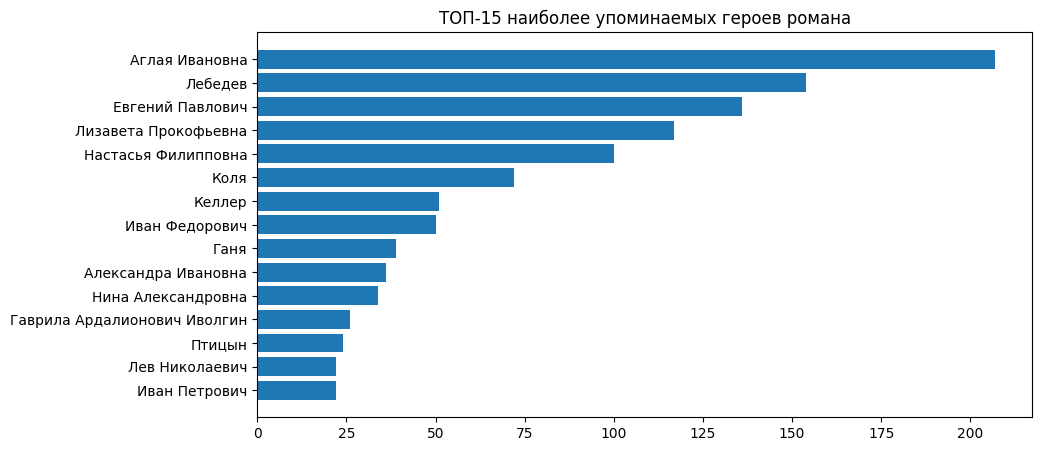

In [77]:
keys = list(top_15_persons.keys())
values = list(top_15_persons.values())

plt.figure(figsize=(10, 5))
plt.barh(keys, values)
plt.title('ТОП-15 наиболее упоминаемых героев романа')
plt.gca().invert_yaxis()
plt.show()

In [78]:
top15_groups = sorted(groups, key=len, reverse=True)[:15]

In [79]:
name_variations = []
for group in top15_groups:
    first_words = [name.split()[0] for name in group]
    name_variations.append(first_words)

In [80]:
name_variations = [list(set(name)) for name in name_variations]

In [ ]:
def get_dispersion(text, name_list, flag=None):
    """поиск слова в тексте"""
    if flag:
        return [flag if any(wi in w for wi in name_list) else np.nan for w in text]
    else:
        return [i+1 if word in w else np.nan for i, w in enumerate(text)]

In [82]:
dispersion_results = []

for name_var in name_variations:
    result = get_dispersion(words, name_var, flag=1)
    dispersion_results.append(result)    

C:\Users\Vэл\AppData\Local\Temp\ipykernel_3544\3331035166.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{x:.0f}%' for x in np.linspace(0, 100, 6)])


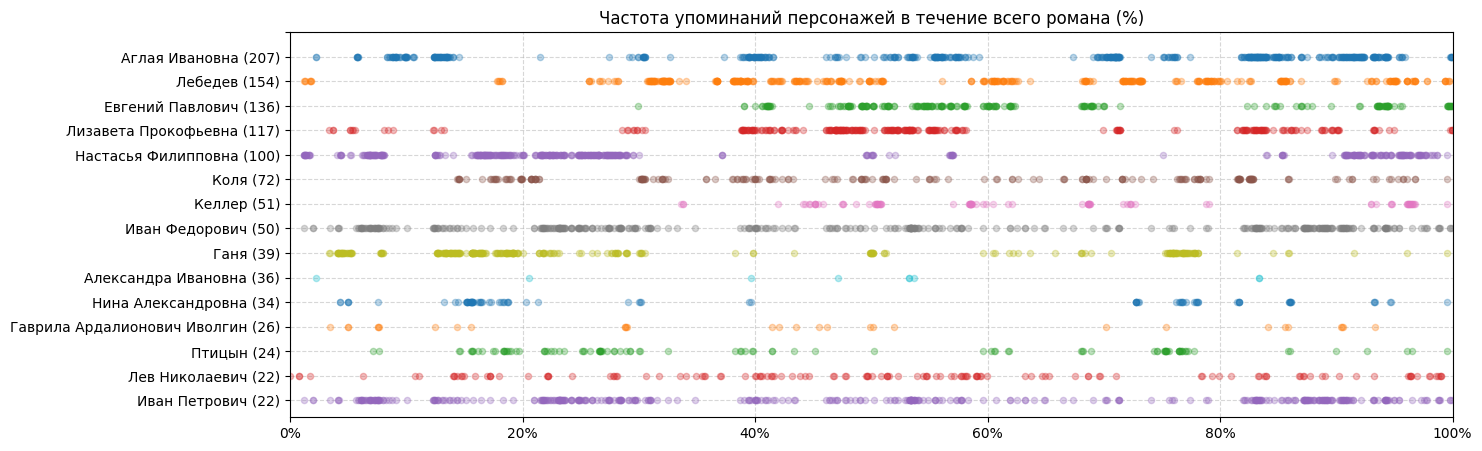

In [83]:
fig, ax = plt.subplots(figsize=(15, 5))

max_length = max(len(res) for res in dispersion_results)


# графики частотности упоминания персон
for i, res in enumerate(dispersion_results):
    offset = i
    y_vals = np.array([np.nan if np.isnan(x) else x + offset for x in res])
    ax.scatter(np.arange(len(y_vals)), y_vals, s=20, alpha=0.3, zorder=2)


xticks_positions = np.linspace(1, 4, 5).astype(int).tolist()
ax.set_xticklabels([f'{x:.0f}%' for x in np.linspace(0, 100, 6)])
ax.set_xticks(np.linspace(0, max_length, 6).astype(int))

ax.set_yticks(range(0, len(keys)+1))
ax.set_yticklabels([''] + [f"{n.title()} ({v})" for n, v in zip(keys, values)])


ax.set_xlim([0, max_length])
ax.set_title('Частота упоминаний персонажей в течение всего романа (%)')
ax.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_yaxis()
plt.show()

---------------------

#### Sentiments

In [ ]:
import pandas as pd
from deeppavlov import build_model, configs

import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
df = pd.read_csv('sentences.csv', encoding ='utf-8')
df = df.dropna()
df['sentences_clear'] = df['sentences_clear'].dropna().fillna('') 

In [39]:
model = build_model(configs.classifiers.rusentiment_bert, download=False)

def get_sentiment(text):
    """определение тональности предложения"""
    result = model([text])
    if isinstance(result, list):
        sentiment = result[0]
    else:
        sentiment = result
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return -1
    else:
        return 0

c:\Аналитика\Для портфолио\.venv\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassif

In [40]:
df['sentiment'] = df['sentences_clear'].apply(get_sentiment)

In [48]:
df.head()

,sentences,sentences_clear,sentiment,rolling_mean,sentiment_smooth
0,ЧАСТЬ ПЕРВАЯI,часть перваяi,0,0.000000,NaN
1,"В конце ноября, в оттепель, часов в девять утр...",конец ноябрь оттепель час девять утро поезд же...,0,0.000000,NaN
2,"Было так сыро и туманно, что насилу рассвело;...",сыро туманно насилу рассвести десять шаг вправ...,-1,-0.333333,NaN
3,Из пассажиров были и возвращавшиеся из-за гра...,пассажир возвращаться граница наполнить отделе...,-1,-0.666667,NaN
4,"Все, как водится, устали, у всех отяжелели за...",водиться устать отяжелеть ночь глаз назябнутьс...,-1,-1.000000,NaN


In [49]:
df['rolling_mean'] = df['sentiment'].rolling(window=3).mean()
df['rolling_mean'] = df['rolling_mean'].fillna(0)

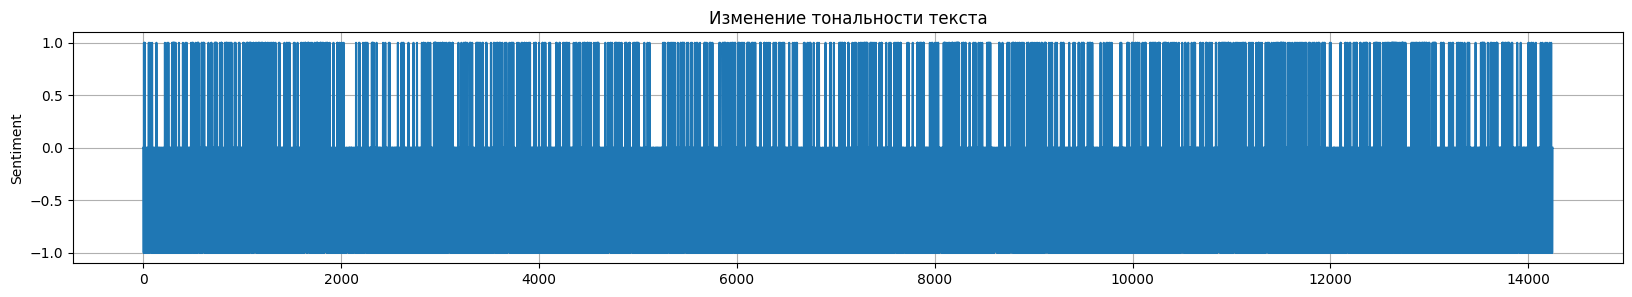

In [51]:
plt.figure(figsize=(20, 3))
plt.plot(df.index, df['sentiment'])
plt.ylabel('Sentiment')
plt.title('Изменение тональности текста')
plt.grid(True)
plt.show()

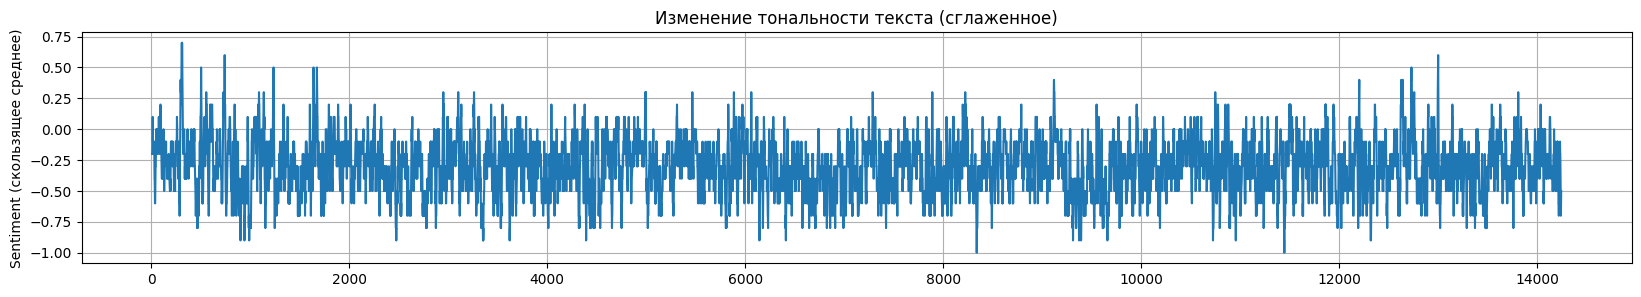

In [52]:
plt.figure(figsize=(20, 3))
df['sentiment_smooth'] = df['sentiment'].rolling(window=10).mean()
plt.plot(df.index, df['sentiment_smooth'])
plt.ylabel('Sentiment (скользящее среднее)')
plt.title('Изменение тональности текста (сглаженное)')
plt.grid(True)
plt.show()

In [53]:
max_ = df['sentiment_smooth'].max()
min_ = df['sentiment_smooth'].min()

In [54]:
for index, row in df.iterrows():
    if row['sentiment_smooth'] == max_:
        print( row['sentences'])

 В обществе они не только не любили выставляться, но даже были слишком скромны
 Одним словом, про них говорилось чрезвычайно много похвального


In [55]:
for index, row in df.iterrows():
    if row['sentiment_smooth'] == min_:
        print(row['sentences'])

 - почти громко проговорил он
 Он был говорлив, беспокоен, заговаривал со всеми встречавшимися с ним с жаром, и как-будто так и набрасываясь на человека, но все о предметах до того разнообразных и неожиданных, что никак нельзя было добиться, что в сущности его так теперь беспокоит
